# TS method illustration

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import gsw
import xarray as xr

%matplotlib inline

#### Parameters

In [2]:
# domain dimensions:
imin, imax = 1139, 2179
jmin, jmax = 159, 799

# Rimwidths:
rimwidthN  = 10
rimwidthS  = 10
rimwidthW  = 10
rimwidthE  = 20

# Boundary coordinates: (i1,i2,j1,j2)
bdy_NCB = (1598,2177,778,798) # Northern Canada Basin 
bdy_WCB = (2168,2178,390,797) # Western Canada Basin 
bdy_LS  = (1140,1150,446,672) # Baffin Bay
bdy_HB  = (1190,1472,293,303) # Hudson Bay

In [3]:
# Colors
land_color = '#a9a7a2'
color_sBB  = '#cc0e1d'
color_sGR  = '#ffb7aa'
light_gray = '#b1b1b1'
light_land = '#d0d0cf'
land_edge  = '#929291'

#### Load files

In [4]:
mesh         = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
mesh_lon     = np.array(mesh.variables['nav_lon'])
mesh_lat     = np.array(mesh.variables['nav_lat'])
mesh_bathy   = np.array(mesh.variables['tmask'][0,:,:,:])
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
depths       = np.array(mesh.variables['nav_lev'])

In [51]:
# temperature and salinity at start of time series:
df_gridT = xr.open_dataset(f'/data/brogalla/ANHA12/ANHA12-EXH006_5d_gridT_y2002m01d05.nc')
temp = df_gridT['votemper'].values[0,:,:,:]
sal  = df_gridT['vosaline'].values[0,:,:,:]

Pb observations:

In [5]:
folder= '/ocean/brogalla/GEOTRACES/data/'

# ------ North Atlantic Ocean, Labrador Sea, Baffin Bay GEOTRACES data -----------
# Observations from: GEOTRACES IDP 2021
df_SW = xr.open_dataset(f'{folder}BB-NA-IDP2021_GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1_mX0n8Urd.nc')
SW_ini_lons = df_SW['longitude'].values # degrees east
SW_ini_lats = df_SW['latitude'].values
SW_ini_pressure   = df_SW['var1'].values # pressure from CTD sensor in dbar
SW_ini_depths     = df_SW['var2'].values # depth below sea surface calculated from pressure
SW_ini_temp_C     = df_SW['var3'].values # temperature from CTD sensor in ITS-90 convention
SW_ini_sal_pss78  = df_SW['var4'].values # practical salinity from CTD sensor in PSS-1978 scale
SW_ini_dPb_pmolkg = df_SW['var9'].values # concentration of dissolved Pb in pmol/kg 
SW_ini_dPb_qc     = df_SW['var9_qc'].values # dPb quality control flag (49-good, 50-prob good, 51-prob bad, 52-bad)

SW_Pb_stns = np.array([])
for stn in range(0,len(SW_ini_lons)):
    if sum(~np.isnan(SW_ini_dPb_pmolkg[stn,:])) > 0: # count number of non NaN Pb values at this station
        SW_Pb_stns = np.append(SW_Pb_stns, stn)
        
# SW_Pb_stns contains the indices of stations that have Pb observations
SW_lons       = np.array([SW_ini_lons[int(i)] for i in SW_Pb_stns])
SW_lats       = np.array([SW_ini_lats[int(i)] for i in SW_Pb_stns])
SW_pres       = np.array([SW_ini_pressure[int(i),:] for i in SW_Pb_stns])
SW_dept       = np.array([SW_ini_depths[int(i),:] for i in SW_Pb_stns])
SW_temp       = np.array([SW_ini_temp_C[int(i),:] for i in SW_Pb_stns])
SW_sals       = np.array([SW_ini_sal_pss78[int(i),:] for i in SW_Pb_stns])
SW_dPb_pmolkg = np.array([SW_ini_dPb_pmolkg[int(i),:] for i in SW_Pb_stns])
SW_dPb_qc     = np.array([SW_ini_dPb_qc[int(i),:] for i in SW_Pb_stns])

#-- Unit conversions: ----
SW_lons_tile = np.tile(SW_lons, (268,1)).transpose()
SW_lats_tile = np.tile(SW_lats, (268,1)).transpose()
# practical salinity --> absolute salinity (g/kg)
SW_sal_abs   = gsw.conversions.SA_from_SP(SW_sals, SW_pres, SW_lons_tile, SW_lats_tile)
# calculate density: uses in situ temperature, absolute salinity, sea pressure 
SW_density   = gsw.density.rho_t_exact(SW_sal_abs, SW_temp, SW_pres) # kg/m3
SW_dPb_pmolL = SW_dPb_pmolkg * SW_density * 1e-3 # dPb in pmol/kg --> pmol/L

# Apply quality control flags (remove bad and probably bad values)
SW_dPb_pmolL[SW_dPb_qc == 51] = np.nan
SW_dPb_pmolL[SW_dPb_qc == 52] = np.nan

In [6]:
# ------ Arctic Ocean data -----------
# Observations from: GEOTRACES IDP 2021
df_NW = xr.open_dataset(f'{folder}AO-IDP2021_GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1_H8oFfvOt.nc')
NW_ini_lons = df_NW['longitude'].values # degrees east
NW_ini_lats = df_NW['latitude'].values
NW_ini_pressure   = df_NW['var1'].values # pressure from CTD sensor in dbar
NW_ini_depths     = df_NW['var2'].values # depth below sea surface calculated from pressure
NW_ini_temp_C     = df_NW['var3'].values # temperature from CTD sensor in ITS-90 convention
NW_ini_sal_pss78  = df_NW['var4'].values # practical salinity from CTD sensor in PSS-1978 scale
NW_ini_dPb_pmolkg = df_NW['var9'].values # concentration of dissolved Pb in pmol/kg 
NW_ini_dPb_qc     = df_NW['var9_qc'].values # dPb quality control flag (49-good, 50-prob good, 51-prob bad, 52-bad)

NW_Pb_stns = np.array([])
for stn in range(0,len(NW_ini_lons)):
    if sum(~np.isnan(NW_ini_dPb_pmolkg[stn,:])) > 0: # count number of non NaN Pb values at this station
        NW_Pb_stns = np.append(NW_Pb_stns, stn)
        
# SW_Pb_stns contains the indices of stations that have Pb observations
NW_lons       = np.array([NW_ini_lons[int(i)] for i in NW_Pb_stns])
NW_lats       = np.array([NW_ini_lats[int(i)] for i in NW_Pb_stns])
NW_pres       = np.array([NW_ini_pressure[int(i),:] for i in NW_Pb_stns])
NW_dept       = np.array([NW_ini_depths[int(i),:] for i in NW_Pb_stns])
NW_temp       = np.array([NW_ini_temp_C[int(i),:] for i in NW_Pb_stns])
NW_sals       = np.array([NW_ini_sal_pss78[int(i),:] for i in NW_Pb_stns])
NW_dPb_pmolkg = np.array([NW_ini_dPb_pmolkg[int(i),:] for i in NW_Pb_stns])
NW_dPb_qc     = np.array([NW_ini_dPb_qc[int(i),:] for i in NW_Pb_stns])

#-- Unit conversions: ----
NW_lons_tile = np.tile(NW_lons, (345,1)).transpose()
NW_lats_tile = np.tile(NW_lats, (345,1)).transpose()
# practical salinity --> absolute salinity (g/kg)
NW_sal_abs   = gsw.conversions.SA_from_SP(NW_sals, NW_pres, NW_lons_tile, NW_lats_tile)
# calculate density: uses in situ temperature, absolute salinity, sea pressure 
NW_density   = gsw.density.rho_t_exact(NW_sal_abs, NW_temp, NW_pres) # kg/m3
NW_dPb_pmolL = NW_dPb_pmolkg * NW_density * 1e-3 # dPb in pmol/kg --> pmol/L

# Apply quality control flags (remove bad and probably bad values)
NW_dPb_pmolL[NW_dPb_qc == 51] = np.nan
NW_dPb_pmolL[NW_dPb_qc == 52] = np.nan

# Separate into northern Canada Basin and western Canada Basin:
nCB_dPb_pmolL = NW_dPb_pmolL[2:11,:]
nCB_sals      = NW_sals[2:11,:]
nCB_temp      = NW_temp[2:11,:]

wCB_dPb_pmolL = np.vstack([NW_dPb_pmolL[1:4,:], NW_dPb_pmolL[17:21,:]])
wCB_sals      = np.vstack([NW_sals[1:4,:], NW_sals[17:21,:]])
wCB_temp      = np.vstack([NW_temp[1:4,:], NW_temp[17:21,:]])

#### Functions

In [7]:
def load_climatology(year, month):        
    # load year 2015 climatology of ANHA12 gridT file:
    df_gridT = xr.open_dataset(f'/data/brogalla/ANHA12/new_averages/gridT_{year}_{month:02}.nc')
    
    bdy_temp = df_gridT['votemper'].values[:,:,:]
    bdy_sal  = df_gridT['vosaline'].values[:,:,:]
    
    return bdy_temp, bdy_sal

#### Calculations

In [8]:
year=2015
month=8

T, S = load_climatology(year, month)

LS_T  = T[:,bdy_LS[0]:bdy_LS[0]+rimwidthS,bdy_LS[2]:bdy_LS[3]]
LS_S  = S[:,bdy_LS[0]:bdy_LS[0]+rimwidthS,bdy_LS[2]:bdy_LS[3]]
nCB_T = T[:,bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]+rimwidthE]
nCB_S = S[:,bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]+rimwidthE]
wCB_T = T[:,bdy_WCB[0]:bdy_WCB[0]+rimwidthN,bdy_WCB[2]:bdy_WCB[3]]
wCB_S = S[:,bdy_WCB[0]:bdy_WCB[0]+rimwidthN,bdy_WCB[2]:bdy_WCB[3]]
HB_T  = T[:,bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]+rimwidthW] 
HB_S  = S[:,bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]+rimwidthW]

Boundary conditions:

In [9]:
BC      = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Pb-tuning-202303/Pb_OBC_y2015m08.nc','r')
dPb_LS  = np.array(BC.variables['dPb_S']).reshape(50,rimwidthS,bdy_LS[3]-bdy_LS[2], order='C')
dPb_wCB = np.flip(np.array(BC.variables['dPb_N']).reshape(50,rimwidthN,bdy_WCB[3]-bdy_WCB[2], order='C'), axis=1)
dPb_nCB = np.flip(np.array(BC.variables['dPb_E']).reshape(50,rimwidthE,bdy_NCB[1]-bdy_NCB[0], order='F'), axis=2)
dPb_HB  = np.array(BC.variables['dPb_W']).reshape(50,rimwidthW,bdy_HB[1]-bdy_HB[0], order='F')
BC.close()

In [52]:
temp.shape

(50, 2400, 1632)

#### Figures

(21.0, 35.5)

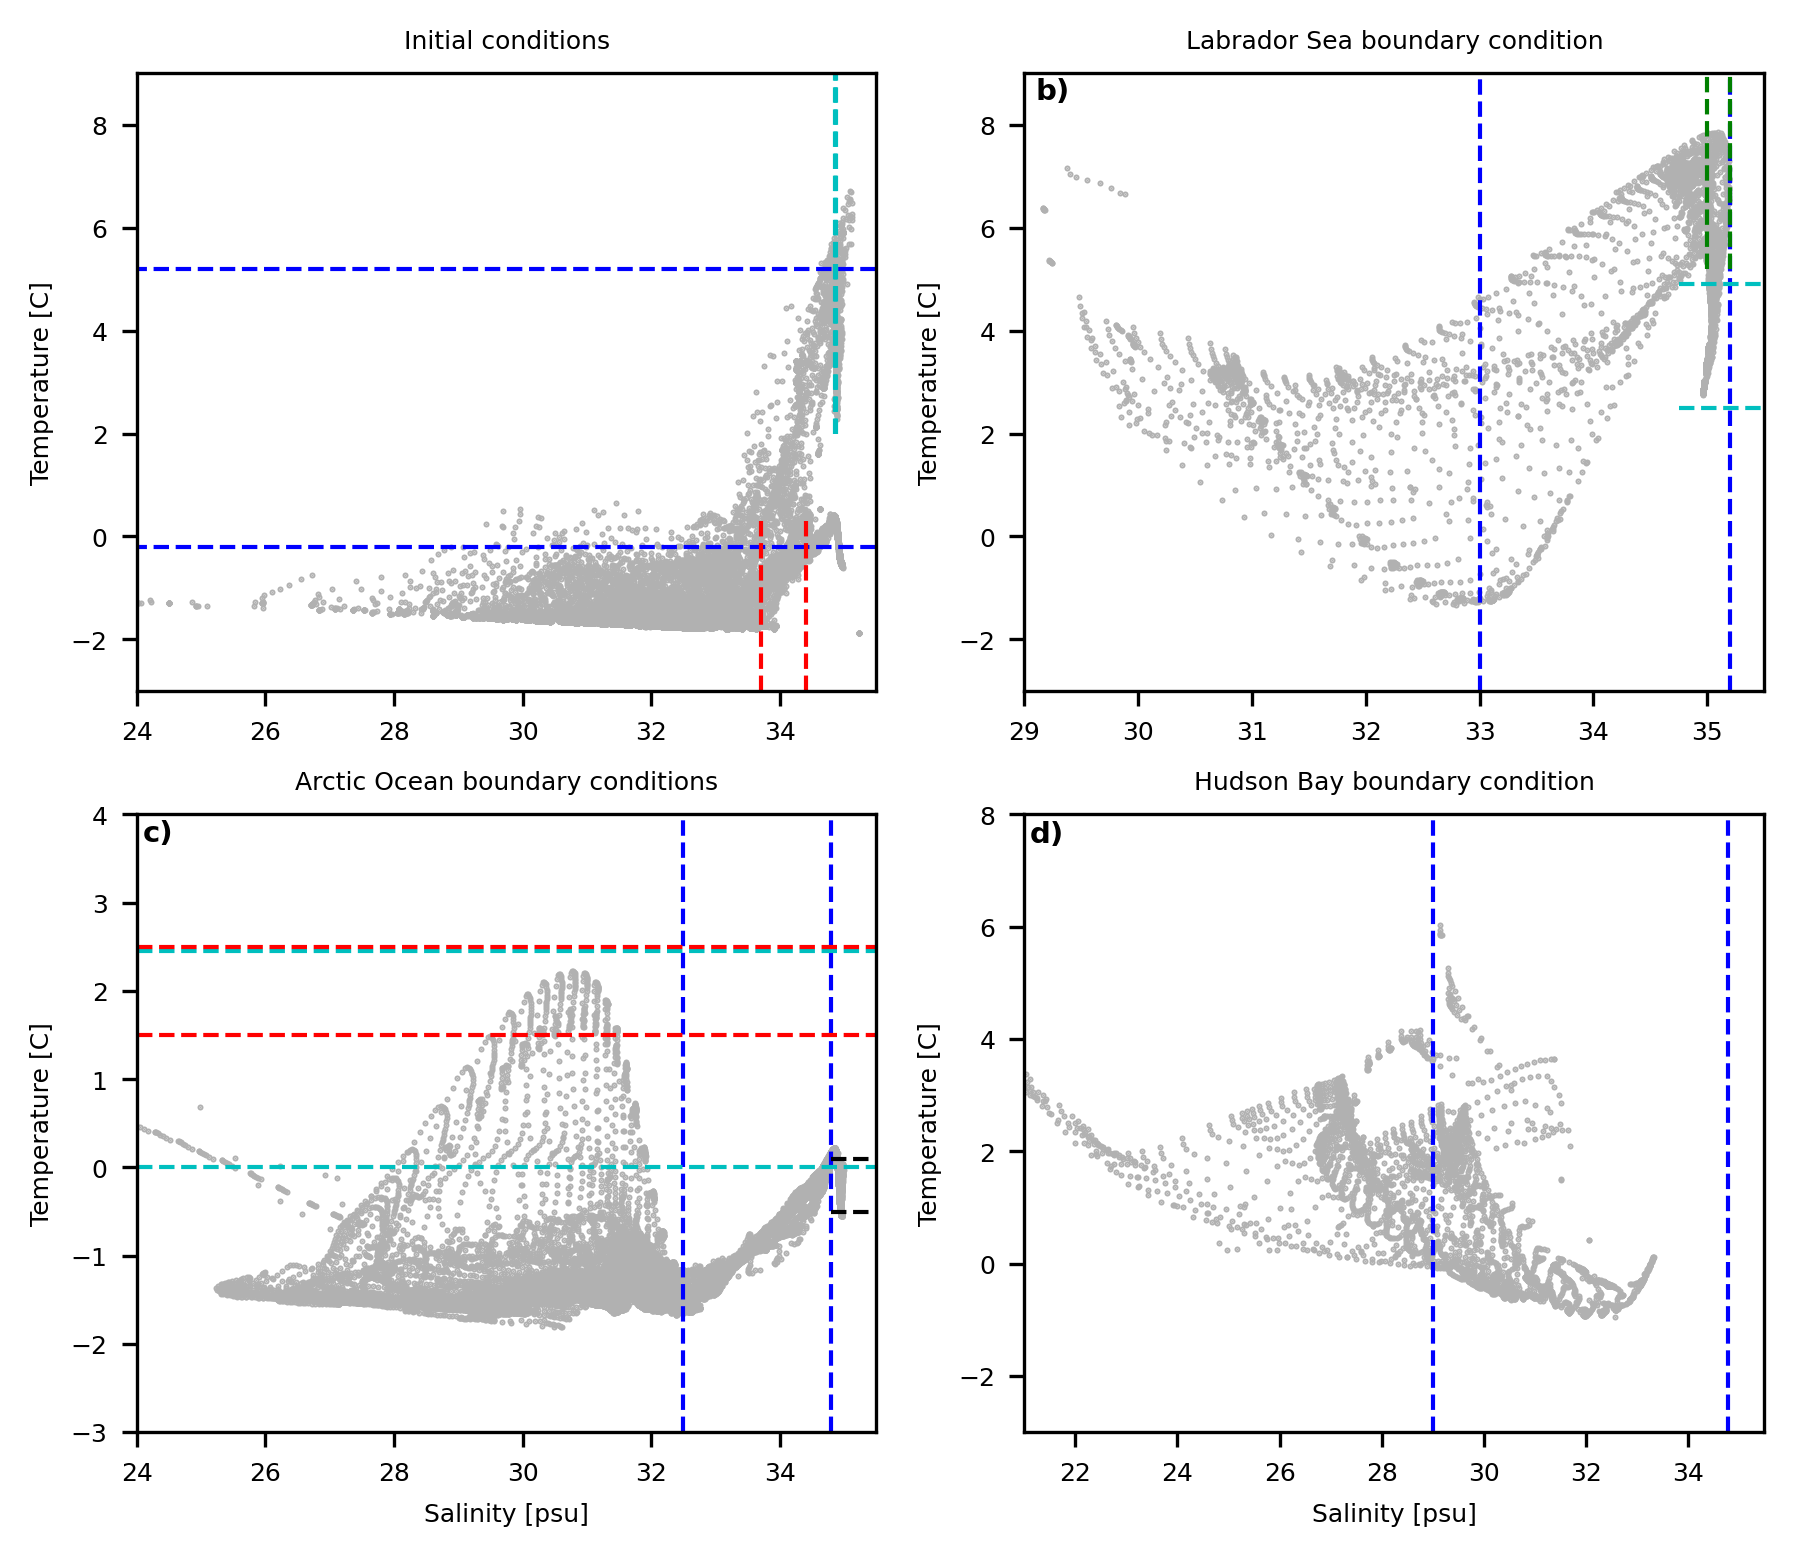

In [58]:
fig, ax = plt.subplots(2,2, figsize=(7.0,6), dpi=300)

for n,axis in enumerate(ax.ravel()):
    axis.tick_params(axis='both', labelsize=6)
    axis.set_ylabel('Temperature [C]', fontsize=6)
    
ax[1,0].set_xlabel('Salinity [psu]', fontsize=6)
ax[1,1].set_xlabel('Salinity [psu]', fontsize=6)
    
ax[0,0].set_title('Initial conditions', fontsize=6)
ax[0,1].set_title('Labrador Sea boundary condition', fontsize=6)
ax[1,0].set_title('Arctic Ocean boundary conditions', fontsize=6)
ax[1,1].set_title('Hudson Bay boundary condition', fontsize=6)

# ax[0,0].text(29.1, 8.5, 'a)', fontsize=7, weight='bold');
ax[0,1].text(29.1, 8.5, 'b)', fontsize=7, weight='bold');
ax[1,0].text(24.1, 3.7, 'c)', fontsize=7, weight='bold');
ax[1,1].text(21.1, 7.5, 'd)', fontsize=7, weight='bold');

#----- Initial conditions: -----------------------------------------------------------
ax[0,0].scatter(sal[:,imin:imax,jmin:jmax][:,::20,::20], temp[:,imin:imax,jmin:jmax][:,::20,::20], \
                c=light_gray, s=0.2, zorder=1, alpha=1)
ax[0,0].plot([20,36],[-0.2,-0.2], '--b', linewidth=1)
ax[0,0].plot([20,36],[5.2,5.2], '--b', linewidth=1)
ax[0,0].plot([34.86,34.86]  ,[2.0,9], '--c', linewidth=1)
ax[0,0].plot([34.875,34.875],[2.0,9], '--c', linewidth=1)
ax[0,0].plot([33.7,33.7],[-3,0.4], '--r', linewidth=1)
ax[0,0].plot([34.4,34.4],[-3,0.4], '--r', linewidth=1)
ax[0,0].set_ylim(-3,9)
ax[0,0].set_xlim(24,35.5)

#----- Labrador Sea: -----------------------------------------------------------
layer  = 0
ax[0,1].scatter(LS_S[:,layer,:] , LS_T[:,layer,:] , c=light_gray, s=0.2, zorder=1, alpha=1)
ax[0,1].plot([33, 33],[-3,9], '--b', linewidth=1)
ax[0,1].plot([35.2, 35.2],[-3,9], '--b', linewidth=1)
ax[0,1].plot([34.75, 36],[2.5,2.5], '--c', linewidth=1)
ax[0,1].plot([34.75, 36],[4.9,4.9], '--c', linewidth=1)
ax[0,1].plot([35, 35],[5.2,9], '--g', linewidth=1)
ax[0,1].plot([35.2, 35.2],[5.2,9], '--g', linewidth=1)
ax[0,1].set_ylim(-3,9)
ax[0,1].set_xlim(29,35.5) 

#----- Northern Canada Basin: -----------------------------------------------------------
ax[1,0].scatter(nCB_S[:,:,layer], nCB_T[:,:,layer], c=light_gray, s=0.2, zorder=1, alpha=1)
ax[1,0].plot([32.5, 32.5],[-3,9], '--b', linewidth=1)
ax[1,0].plot([34.8, 34.8],[-3,9], '--b', linewidth=1)
ax[1,0].plot([24,36],[0.0,0.0], '--c', linewidth=1)
ax[1,0].plot([24,36],[2.45,2.45], '--c', linewidth=1)
ax[1,0].plot([24,36],[1.5,1.5], '--r', linewidth=1)
ax[1,0].plot([24,36],[2.5,2.5], '--r', linewidth=1)
ax[1,0].plot([34.8, 36],[0.1,0.1], '--k', linewidth=1)
ax[1,0].plot([34.8, 36],[-0.5,-0.5], '--k', linewidth=1)
#----- Western Canada Basin: ----
ax[1,0].scatter(wCB_S[:,layer,:], wCB_T[:,layer,:], c=light_gray, s=0.2, zorder=1, alpha=1)
ax[1,0].set_ylim(-3,4)
ax[1,0].set_xlim(24,35.5) 

#----- Hudson Bay: -----------------------------------------------------------
ax[1,1].scatter(HB_S[:,:,layer] , HB_T[:,:,layer] , c=light_gray, s=0.2, zorder=1, alpha=1)
ax[1,1].plot([29, 29],[-3,9], '--b', linewidth=1)
ax[1,1].plot([34.8, 34.8],[-3,9], '--b', linewidth=1)
ax[1,1].set_ylim(-3,8)
ax[1,1].set_xlim(21,35.5)